## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [1]:
import os, warnings
os.environ["OMP_NUM_THREADS"] = "2"   # 避免 MKL+Windows 这个 known issue 的内存警告
warnings.filterwarnings(
    "ignore",
    message="KMeans is known to have a memory leak on Windows with MKL",
    category=UserWarning
)
#set file index
p =2

In [2]:
# The structure of data folder.
!ls -l data

total 72
drwxrwxrwx@ 41 carmenfung  staff   1312  8 25  2018 CroppedYaleB
-rw-r--r--@  1 carmenfung  staff    461 10  8 00:07 CroppedYaleB_cim_result_init1.csv
-rw-r--r--@  1 carmenfung  staff    737 10  8 01:33 CroppedYaleB_l2_l2_1_result.csv
-rw-r--r--@  1 carmenfung  staff  12278 10  8 09:13 CroppedYaleB_l2_l2_1_result.xlsx
-rw-r--r--@  1 carmenfung  staff    398 10  8 03:33 CroppedYaleB_result.csv
-rw-r--r--@  1 carmenfung  staff    593 10  8 09:04 CroppedYaleB_result_l2-l21.csv
drwx------@ 44 carmenfung  staff   1408  8 24  2018 ORL
-rw-r--r--   1 carmenfung  staff    239 10  8 11:05 ORL_result.csv
-rw-r--r--@  1 carmenfung  staff   1651 10  8 10:13 ORL_result_3次.csv


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [3]:
import os
import numpy as np
from PIL import Image

#record the path to reload the origin data

def load_data(root='data/CroppedYaleB'):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels,paths = [], [],[]

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            #new -record the path
            img_path = os.path.join(root, person, fname)
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            # img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.
            # --- c fixed size (keeps PIL (W,H) order) ---
            root_name = os.path.basename(os.path.normpath(root)).lower()
            if 'orl' in root_name:
                img = img.resize((30, 37), resample=Image.BILINEAR)
            elif 'yaleb' in root_name or 'croppedyaleb' in root_name:
                img = img.resize((42, 48), resample=Image.BILINEAR)

            # --- normalize to [0,1] (nonnegative, NMF-safe) ---
            arr = np.asarray(img, dtype=np.float64) / 255.0
            # convert image to numpy column vector (after preprocessing).
            img = arr.reshape((-1, 1))

            #no-normalize
            img = np.asarray(img).reshape((-1,1))




            # collect data and label.
            images.append(img)
            labels.append(i)
            #collect the path
            paths.append(img_path)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

## 2. 胡椒函数 +对应的噪音图展示 



In [4]:
import numpy as np
import matplotlib.pyplot as plt

#看起来正确的胡椒算法
def add_salt_pepper_noise(V, p= None, r=None, rng=None):
    V_noisy = V.copy()
    d, n = V.shape
    total_pixels = d * n
    num_corrupt = int(total_pixels * p)


    idx = rng.choice(total_pixels, size=num_corrupt, replace=False)
    num_white = int(num_corrupt * r)
    white_idx = idx[:num_white]
    black_idx = idx[num_white:]


    V_noisy.flat[white_idx] = 1.0
    V_noisy.flat[black_idx] = 0.0
    return V,V_noisy

# Plot result. 
def plot_noise_pic(V_hat,img_size,ind = None, noise_list=None):
    total = 1+len(noise_list)
    rng_init = np.random.RandomState(1)
    plt.figure(figsize=(10,4))
    plt.subplot(1, total, 1)
    plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title('Image(Original)')
    i = 2
    for (p, r) in noise_list:
        V_hat ,V  = add_salt_pepper_noise(V=V_hat,p=p,r=r,rng= rng_init )
        # Plot result. 
        plt.subplot(1, total, i)
        plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray,vmin= 0,vmax=1)
        plt.title("p={}, r={}".format(p, r))
        i+=1
    plt.tight_layout(pad=2.0)
    plt.show()
    






## 3. NMF代码实现 + NMF之后的可视化展示


In [5]:
#计算两个目标值之间的相对改进量
def relative_improvement(prev_obj, curr_obj, eps=1e-12):
    return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)

#定义统一的可视化函数
def visualize_reconstruction(V_hat, V_noisy, V_recon, ind=50, img_size=(92,112), title="NMF Reconstruction"):
    plt.suptitle(title, size=16)

    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(V_hat[:, ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title("Image (Original)")

    plt.subplot(132)
    plt.imshow(V_noisy[:, ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title("Image (Noisy)")

    plt.subplot(133)
    plt.imshow(V_recon[:, ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
    plt.title("Image (Reconstructed)")

    plt.show()
    
eps = 1e-12

### 3.1 L1-NMF代码实现+实现后的效果可视化

In [6]:
def L1_nmf(V, H, W, steps=3000, tol=1e-4, *,  # tol略放宽
           eps=1e-4,          # 稳定权重/分母，略放大
           omega_cap=1e3,     # 权重上限，避免过激
           alpha=0.5,         # 更新“降幂”=步长，0<alpha<=1
           floor=1e-12,       # 非负下限避免死列
           min_steps=100,     # 跑够一定步数再允许早停
           verbose=False):
    """Minimal but stabilized L1-NMF (IRLS + MU, few guards)."""
    V = np.maximum(np.asarray(V, float), floor)
    W = np.maximum(np.asarray(W, float), floor)
    H = np.maximum(np.asarray(H, float), floor)

    obj_prev = np.sum(np.abs(V - W @ H))

    for step in range(1, steps + 1):
        # IRLS权重：Ω = 1/(|E|+eps)，并裁顶
        E = V - (W @ H)
        Q = 1.0 / (np.abs(E) + eps)
        Q = np.minimum(Q, float(omega_cap))

        # --- 更新H（降幂 alpha 抑制过冲）---
        WH   = W @ H
        numH = W.T @ (Q * V)
        denH = W.T @ (Q * WH) + eps
        ratioH = numH / denH
        H = np.maximum(H * (ratioH ** alpha), floor)

        # --- 更新W（降幂 alpha）---
        WH   = W @ H
        numW = (Q * V) @ H.T
        denW = (Q * WH) @ H.T + eps
        ratioW = numW / denW
        W = np.maximum(W * (ratioW ** alpha), floor)

        # --- 列归一化W（稳尺度），尺度乘回H ---
        s = np.maximum(np.linalg.norm(W, axis=0), floor)
        W /= s
        H *= s[:, None]

        # --- 早停判据（相对改进）---
        obj = np.sum(np.abs(V - W @ H))
        rel = abs(obj_prev - obj) / (obj_prev + 1e-12)
        if verbose and step % 100 == 0:
            print(f"[L1-NMF] step={step:4d}  L1={obj:.6e}  rel={rel:.3e}")
        if (step >= min_steps) and (rel < tol):
            if verbose:
                print(f"[L1-NMF] Converged at step={step}, L1={obj:.6e}, rel={rel:.3e}")
            break
        obj_prev = obj

    return W, H, step

### 3.2 L2-NMF代码实现+实现后的效果可视化


For any data matrix $X$, L2-NMF finds non-negative factors $D \in \mathbb{R}^{w \times k}_{+}$ and $R \in \mathbb{R}^{k \times n}_{+}$ such that
$$
X \approx DR,
$$
by minimizing the Frobenius reconstruction error
$$
\min_{D,R \ge 0}\ \lVert X - DR \rVert_F^2 .
$$

Using multiplicative update rules (MUR), the iteration can be written as
$$
R \leftarrow R \odot \frac{D^\top X}{D^\top D R}, \qquad
D \leftarrow D \odot \frac{X R^\top}{D R R^\top},
$$
where $\odot$ denotes element-wise multiplication.



---------------------------


In [7]:
def L2_NMF(V,H,W,steps,tol=1e-5,verbose=False):
    # H is coeffient matrix
    # W is dictionary matrix
    # V is the matrix with noise
    #V hat  is the original matrix
    # print("basic_NMF")
    obj_prev = np.linalg.norm(V - W @ H, 'fro')**2
    
    for step in range(1, steps+1):    

        H_star = H * (W.T.dot(V)) / (W.T.dot(W).dot(H) + eps)
        W_star = W * (V.dot(H_star.T)) / (W.dot(H_star.dot(H_star.T)) + eps)

        H, W = H_star, W_star

        obj = np.linalg.norm(V - W @ H, 'fro')**2

        rel_impr = relative_improvement(obj_prev, obj, eps=eps)

        if rel_impr < tol:
            if verbose:
                print(f"Converged at step={step}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")
            break

        obj_prev = obj

        if verbose and step in (1000, 5000, 10000, 15000, 20000):
            print(f"step={step}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")

    return W,H, step


### 3.3 L2,1-NMF代码实现+实现后的效果可视化

In [8]:
def L21_nmf(V, H, W, steps=3000, tol=1e-5, verbose=False,eps = 1e-8,alpha = 1):

    def L21_obj(E):
        return np.sum(np.sqrt(np.sum(E * E, axis=1) + eps))

    obj_prev = L21_obj(V - W @ H)

    for step in range(1, steps + 1):
        # 残差 & 行权重
        E = V - (W @ H)                               # (d, n)
        row_norm = np.sqrt(np.sum(E * E, axis=1) + eps)  # (d,)
        s = 1.0 / (row_norm**alpha + eps)                    # (d,)

        # 广播实现 S = diag(s)
        SV  = s[:, None] * V
        SWH = s[:, None] * (W @ H)

        # H <- H .* (W^T (S V)) / (W^T (S W H))
        H *= (W.T @ SV) / (W.T @ SWH + eps)

        # W <- W .* ((S V) H^T) / ((S W H) H^T)
        SWH = s[:, None] * (W @ H)                    # 用更新后的 H 重新计算
        W  *= (SV @ H.T) / (SWH @ H.T + eps)

        # 收敛判定（相对改进）
        obj = L21_obj(V - W @ H)
        rel = relative_improvement(obj_prev, obj, eps=eps)
        # if verbose and (step % 100 == 0):
        #     print(f"[L2,1-NMF] step={step}, obj={obj:.6e}, rel={rel:.3e}")
        if rel < tol:
            if verbose:
                print(f"[L2,1-NMF] Converged at step={step}, obj={obj:.6e}, rel={rel:.3e}")
            break
        obj_prev = obj

    return W, H, step



### 3.4 CIM-NMF代码实现+实现后的效果可视化

For any data matrix $X$, CIM-NMF finds non-negative factors 
$D \in \mathbb{R}_+^{d \times k}$ and 
$R \in \mathbb{R}_+^{k \times n}$ such that

$$
X \approx DR,
$$

by minimizing the Correntropy-Induced Metric (CIM) reconstruction error:

$$
\min_{D,R \ge 0} \sum_{i=1}^d \sum_{j=1}^n 
\left( 1 - \frac{1}{\sqrt{2\pi}\delta} 
\exp\!\left(-\frac{(X_{ij} - (DR)_{ij})^2}{2\delta^2}\right) \right).
$$

---

### Multiplicative Update Rules (MUR)

Using the weight matrix

$$
W_{ij} = \frac{1}{\sqrt{2\pi}\delta} 
\exp\!\left(-\frac{(X_{ij} - (DR)_{ij})^2}{2\delta^2}\right),
$$

the iteration can be written as

$$
R \leftarrow R \odot \frac{D^\top (W \odot X)}{D^\top (W \odot (DR))}, 
\qquad
D \leftarrow D \odot \frac{(W \odot X) R^\top}{(W \odot (DR)) R^\top},
$$

where $\odot$ denotes element-wise multiplication.

In [9]:
def cim_nmf(V, H,W, max_iter=300, tol=1e-5, rng=None, verbose=False,delta = 1,eps = 1e-12,default =1):
    """
    CIM-NMF (Correntropy-Induced Metric NMF)
    min_{W,H >=0} sum_{ij} r((V-WH)_{ij}, delta)

    更新规则基于权重加权的 NMF:
      H <- H * (W^T (R ⊙ V)) / (W^T (R ⊙ WH))
      W <- W * ((R ⊙ V) H^T) / ((R ⊙ WH) H^T)
    其中 R = exp(-(E^2)/(2 delta^2)) / (sqrt(2π) delta)
    """

    # m, n = V.shape
    # rng = np.random.default_rng(rng)
    # W = np.maximum(rng.random((m, k)), 1e-8)
    # H = np.maximum(rng.random((k, n)), 1e-8)
    if default == 1:
        obj_prev = np.inf
    elif default ==2:
        def cim_objective(V, W, H, delta, r_floor=1e-6):
        E = V - W @ H
        R = np.exp(-(E**2) / (2.0 * (delta**2)))
        R = np.clip(R, r_floor, 1.0)
        return np.sum(1.0 - R)
        obj0 = cim_objective(V, W, H, sigma)   # 第0步先算一次
        obj_prev = obj0 * (1 + 1e-3)           # 轻微放大，避免第一步相对改进为0/不稳定

    eps = eps
    # delta = 1

    for it in range(1, max_iter + 1):
        # restucture
        V_hat = W @ H
        E = V - V_hat

        R = np.exp(-(E**2) / (2 * delta**2)) / (np.sqrt(2*np.pi) * delta)

        obj = np.sum(1 - R)

        # update H
        H *= (W.T @ (R * V)) / (W.T @ (R * V_hat) + eps)
        # update W
        V_hat = W @ H
        W *= ((R * V) @ H.T) / ((R * V_hat) @ H.T + eps)

        rel_impr = relative_improvement(obj_prev, obj, eps)
        if rel_impr < tol:
            # if verbose:
            #     print(f"[CIM-NMF] Converged at iter={it}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")
            break
        obj_prev = obj

        # if verbose and it % 50 == 0:
        #     print(f"[CIM-NMF] iter={it}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")

    return W, H, it


## 4. Evaluation Metrics


### 4.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [10]:
# # Evaluate relative reconstruction errors.
# 每个算法跑5次
def RRE_calcu(V_hat,V_star,algo,iter_time):
    # print(f"==> Evaluate RRE for {algo} for the {iter_time} time ")
    RRE = np.linalg.norm(V_hat - V_star) / np.linalg.norm(V_hat)
    # print('RRE = {}'.format(RRE))
    return RRE

### 4.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [11]:
#other evaluate -检测指标
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y,local_seed,n_init):
    kmeans = KMeans(n_clusters=len(set(Y)),random_state = local_seed,n_init=n_init).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred


def accu_calcu(H,Y_hat,algo,iter_time,local_seed,n_init=10):
    print(f"==> Evaluate Acc and NMI for {algo} for the {iter_time} time ")
    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y_hat,local_seed,n_init=n_init)
    
    acc = accuracy_score(Y_hat, Y_pred)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    return acc, nmi



## 5. 执行鲁棒实验

In [12]:
#NMF algo_choice
# ===== L1 =====
def nmf_L1(V, K, local_seed, steps=3000, tol=1e-5, verbose=False):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L1_nmf(V, H, W, steps=steps, tol=tol, verbose=verbose)
    return W_star, H_star,step_star

# ===== L2=====
def nmf_L2(V, K, local_seed, steps=3000, tol=1e-5, verbose=False):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L2_NMF(V, H, W, steps=steps, tol=tol, verbose=verbose)
    return W_star, H_star,step_star

# ===== L2,1 =====
def nmf_L21(V, K, local_seed, steps=3000, tol=1e-5, verbose=False,eps = 1e-8,alpha = 1):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=True)
    return W_star, H_star,step_star

# ===== CIM =====
def nmf_CIM(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 1,eps = 1e-12,default =1.4):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng, verbose=True)
    return W_star, H_star,step_star

#调参
# ===== L2,1 =====
def nmf_L21_alpha(V, K, local_seed, steps=3000, tol=1e-5, verbose=False,eps = 1e-12,alpha = 1.4):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=False,eps = eps,alpha = alpha)
    return W_star, H_star,step_star

def nmf_L21_eps(V, K, local_seed, steps=3000, tol=1e-5, verbose=False,eps = 1e-8,alpha = 1):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=False,eps = eps,alpha = alpha)
    return W_star, H_star,step_star

def nmf_L21_eps_alpha(V, K, local_seed, steps=3000, tol=1e-5, verbose=False,eps = 1e-8,alpha = 0.8):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=False,eps = eps,alpha = alpha)
    return W_star, H_star,step_star

def nmf_CIM_delta(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 0.5,eps = 1e-12,default =1):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng, verbose=False, delta = 0.5,eps = 1e-12,default =1)
    return W_star, H_star,step_star

def nmf_CIM_eps(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 1,eps = 1e-8,default =1):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng,  verbose=False, delta = 1,eps = 1e-8,default =1)
    return W_star, H_star,step_star

def nmf_CIM_default(V, K, local_seed, step=3000, tol=1e-5, verbose=False, delta = 1,eps = 1e-12,default =2):
    rng = np.random.RandomState(local_seed)
    N  = V.shape[1]   
    M  = V.shape[0]
    # init W, H
    W = rng.rand(M, K)
    H = rng.rand(K, N)
    W_star, H_star,step_star = cim_nmf(V, H,W, max_iter=step, tol=tol, rng=rng,  verbose=False, delta = 1,eps = 1e-12,default =default)
    return W_star, H_star,step_star


In [13]:
import pandas as pd
def one_time_nmf(V_hat_all,Y_hat_all,algo,K,p,r,img_size,iter_time,local_seed):
    rng = np.random.RandomState(local_seed)
    
    #  90% subset
    n = V_hat_all.shape[1]
    m = int(np.ceil(0.9 * n))
    idx = rng.choice(n, size=m, replace=False)   
    V_sub = V_hat_all[:, idx]
    y_sub = Y_hat_all[idx]
    
    #add noise
    V_hat,V_noisy = add_salt_pepper_noise(V_sub, p=p, r=r, rng=rng)

    #algo
    W_star, H_star,step_star = algo(V_hat,K,local_seed)
    V_star = W_star @ H_star
    print(f"{algo} final run step with local_seed{local_seed}:",step_star)
    if iter_time == 0 :
        visualize_reconstruction(V_hat, V_noisy, V_star, 50, img_size, title=f"{algo} Reconstruction")

    #metrics-不确定该部分.应该用
    rre = RRE_calcu(V_hat,V_star,algo,iter_time)
    acc, nmi = accu_calcu(H_star,y_sub,algo,iter_time,local_seed)
    
    return rre, acc, nmi ,step_star
    
def robost_pipeline(dataset, algos, noise_list,n_runs = 1,global_seed = 42):
    #load data
    V_hat, Y_hat = load_data(root=f"data/{dataset}")   
    print(f"{dataset} dataset: X.shape = {V_hat.shape}, Y.shape = {Y_hat.shape}")

    if dataset == "ORL":
        # img_size = (92,112) 
        # img_size = [i//2 for i in (92, 112)] # ORL
        img_size = (30,37)
        K = 40
    elif dataset == "CroppedYaleB":
        # img_size = (168,192)
        # img_size = [i//2 for i in (168,192)] 
        img_size = (42,48)
        K= 38
    else: 
        print("can not find the dataset")
    print("K:",K)

    # Noise visualization
    plot_noise_pic(V_hat, img_size, ind=50, noise_list=noise_list)

    results = []
    #wolk through all the algo
    for algo_index, algo in enumerate(algos):
        #add_noise
        for noise_index,noise in enumerate(noise_list):
            p, r = noise
            rre_results = []
            acc_results = []
            nmi_results = []
            step_results = []
            for i in range(n_runs):
                run_index = i
                local_seed =  global_seed*100+(noise_index+1)*10+run_index
                print(f"algo is {algo},noise is {noise}, iter_time is {run_index}, the local_seed is {local_seed}")

                rre, acc, nmi,step_star  = one_time_nmf(V_hat,Y_hat,algo,K,p,r,img_size,run_index,local_seed)
                rre_results.append(rre)
                acc_results.append(acc)
                nmi_results.append(nmi)
                step_results.append(step_star)
            mean_rre, std_rre = np.mean(rre_results), np.std(rre_results, ddof=1)
            mean_acc, std_acc = np.mean(acc_results), np.std(acc_results, ddof=1)
            mean_nmi, std_nmi = np.mean(nmi_results), np.std(nmi_results, ddof=1)
            mean_step, std_step = np.mean(step_results), np.std(step_results, ddof=1)

            print(f"[Algo={algo.__name__}, Noise={noise}, Run={run_index}] "
                  f"RRE={mean_rre:.4f}±{np.std(std_rre):.4f}, "
                  f"ACC={mean_acc:.4f}±{np.std(std_acc):.4f}, "
                  f"NMI={mean_nmi:.4f}±{np.std(std_nmi):.4f}")
            
            results.append({
                "algo": algo.__name__,
                "noise_p": p,
                "noise_r": r,
                "run_index": run_index,
                "RRE": mean_rre,
                "ACC": mean_acc,
                "NMI": mean_nmi,
                "local_seed" :local_seed,
                "final_step":mean_step
            })
    # 转换成 DataFrame
    df_result = pd.DataFrame(results)

    # 保存成 CSV
    df_result.to_csv(f"data/{dataset}_result.csv", index=False)
    print("save to results.csv")
                    
    

## 6. 结果

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
K: 40


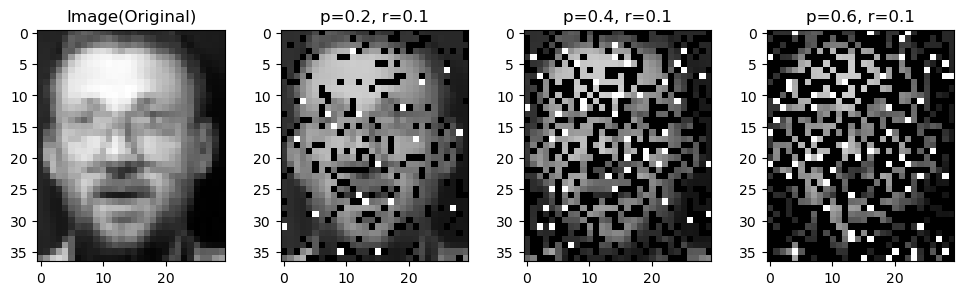

algo is <function nmf_L1 at 0x125827f60>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210
<function nmf_L1 at 0x125827f60> final run step with local_seed4210: 3000


<Figure size 640x480 with 0 Axes>

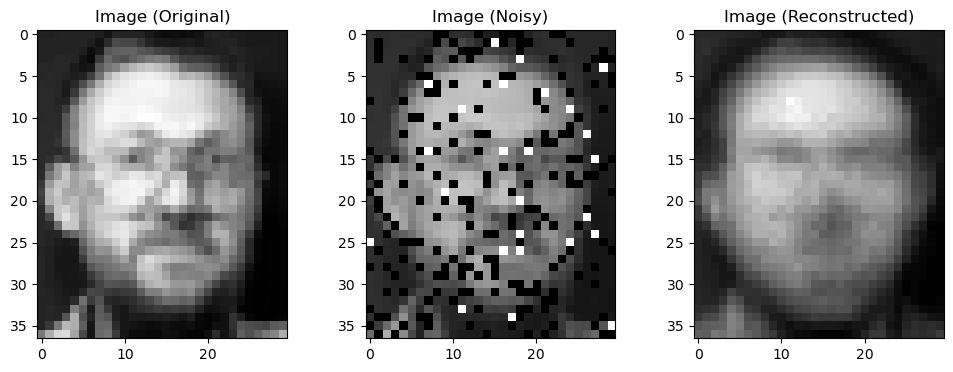

==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 0 time 
Acc(NMI) = 0.7861 (0.8929)
algo is <function nmf_L1 at 0x125827f60>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211
<function nmf_L1 at 0x125827f60> final run step with local_seed4211: 3000
==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 1 time 
Acc(NMI) = 0.7750 (0.8661)
algo is <function nmf_L1 at 0x125827f60>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212
<function nmf_L1 at 0x125827f60> final run step with local_seed4212: 3000
==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 2 time 
Acc(NMI) = 0.7500 (0.8734)
[Algo=nmf_L1, Noise=(0.2, 0.1), Run=2] RRE=0.1365±0.0000, ACC=0.7704±0.0000, NMI=0.8775±0.0000
algo is <function nmf_L1 at 0x125827f60>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220
<function nmf_L1 at 0x125827f60> final run step with local_seed4220: 3000


<Figure size 640x480 with 0 Axes>

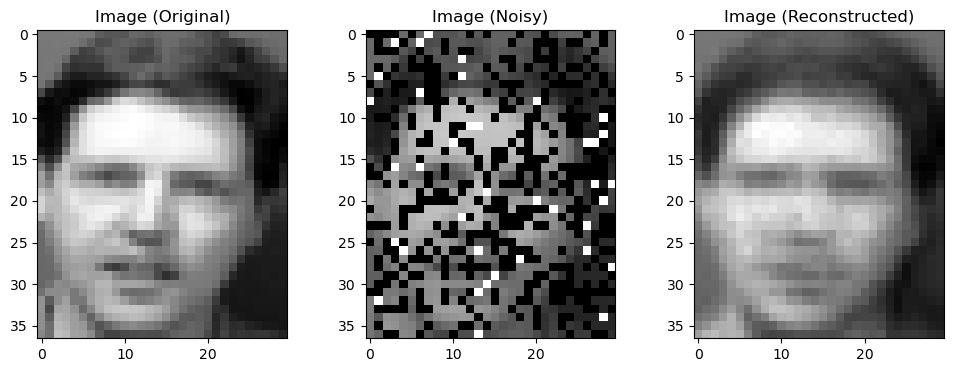

==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 0 time 
Acc(NMI) = 0.7500 (0.8681)
algo is <function nmf_L1 at 0x125827f60>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221
<function nmf_L1 at 0x125827f60> final run step with local_seed4221: 3000
==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 1 time 
Acc(NMI) = 0.7528 (0.8663)
algo is <function nmf_L1 at 0x125827f60>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222
<function nmf_L1 at 0x125827f60> final run step with local_seed4222: 3000
==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 2 time 
Acc(NMI) = 0.7389 (0.8673)
[Algo=nmf_L1, Noise=(0.4, 0.1), Run=2] RRE=0.1373±0.0000, ACC=0.7472±0.0000, NMI=0.8673±0.0000
algo is <function nmf_L1 at 0x125827f60>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230
<function nmf_L1 at 0x125827f60> final run step with local_seed4230: 3000


<Figure size 640x480 with 0 Axes>

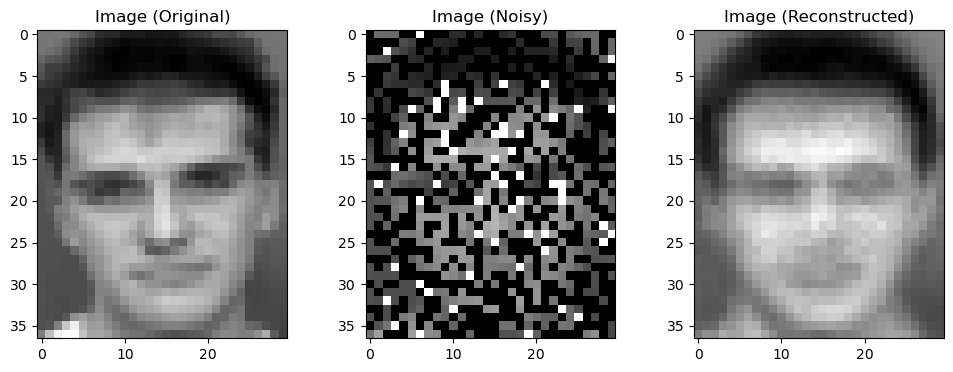

==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 0 time 
Acc(NMI) = 0.7167 (0.8518)
algo is <function nmf_L1 at 0x125827f60>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231
<function nmf_L1 at 0x125827f60> final run step with local_seed4231: 3000
==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 1 time 
Acc(NMI) = 0.7500 (0.8676)
algo is <function nmf_L1 at 0x125827f60>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232
<function nmf_L1 at 0x125827f60> final run step with local_seed4232: 3000
==> Evaluate Acc and NMI for <function nmf_L1 at 0x125827f60> for the 2 time 
Acc(NMI) = 0.7694 (0.8722)
[Algo=nmf_L1, Noise=(0.6, 0.1), Run=2] RRE=0.1377±0.0000, ACC=0.7454±0.0000, NMI=0.8638±0.0000
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4210: 1654


<Figure size 640x480 with 0 Axes>

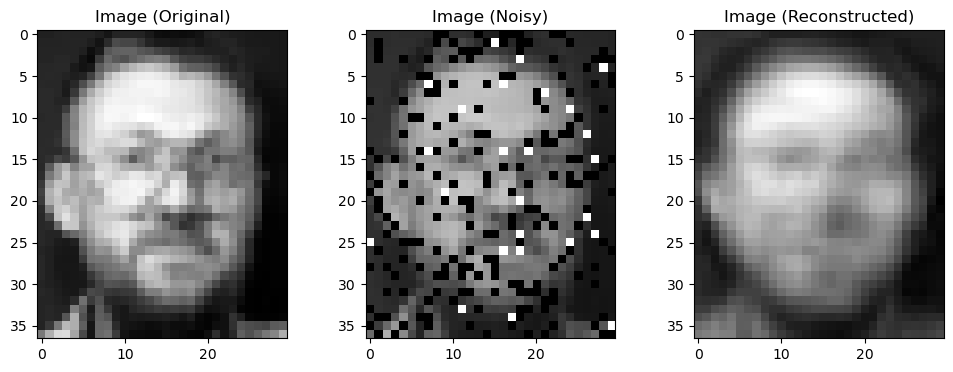

==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 0 time 
Acc(NMI) = 0.7750 (0.8659)
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4211: 1600
==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 1 time 
Acc(NMI) = 0.7694 (0.8662)
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4212: 1620
==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 2 time 
Acc(NMI) = 0.7333 (0.8573)
[Algo=nmf_L21_alpha, Noise=(0.2, 0.1), Run=2] RRE=0.1120±0.0000, ACC=0.7593±0.0000, NMI=0.8632±0.0000
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4220: 

<Figure size 640x480 with 0 Axes>

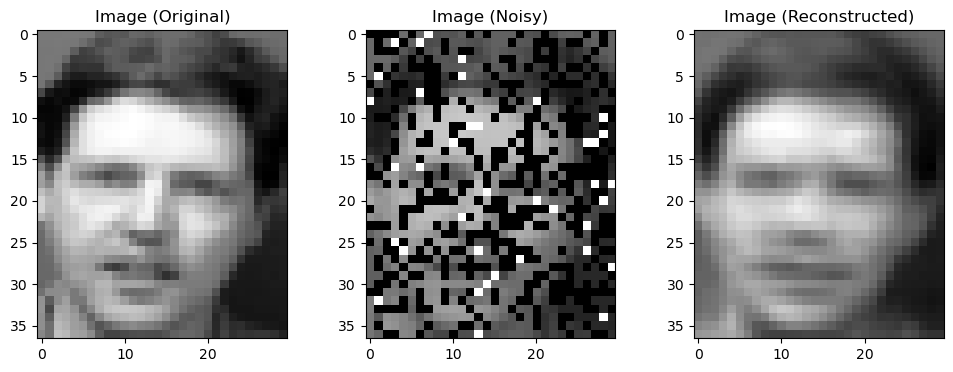

==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 0 time 
Acc(NMI) = 0.7694 (0.8677)
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4221: 1782
==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 1 time 
Acc(NMI) = 0.7611 (0.8684)
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4222: 1700
==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 2 time 
Acc(NMI) = 0.7750 (0.8781)
[Algo=nmf_L21_alpha, Noise=(0.4, 0.1), Run=2] RRE=0.1123±0.0000, ACC=0.7685±0.0000, NMI=0.8714±0.0000
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4230: 

<Figure size 640x480 with 0 Axes>

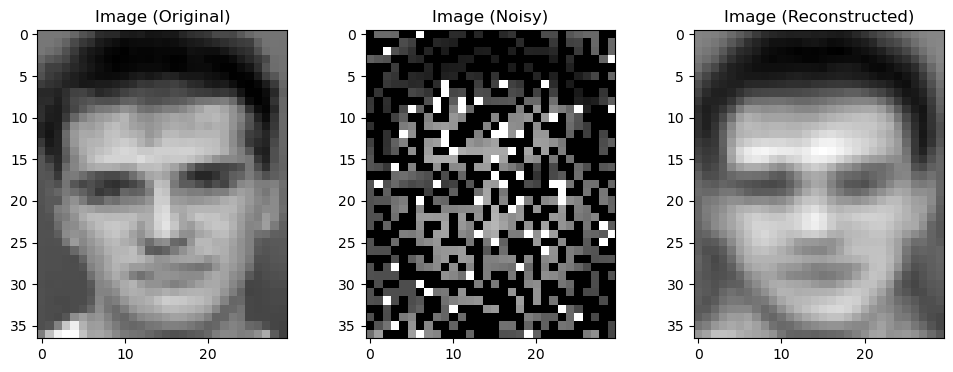

==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 0 time 
Acc(NMI) = 0.7278 (0.8418)
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4231: 1707
==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 1 time 
Acc(NMI) = 0.7639 (0.8717)
algo is <function nmf_L21_alpha at 0x12585c680>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232
<function nmf_L21_alpha at 0x12585c680> final run step with local_seed4232: 1923
==> Evaluate Acc and NMI for <function nmf_L21_alpha at 0x12585c680> for the 2 time 
Acc(NMI) = 0.7083 (0.8335)
[Algo=nmf_L21_alpha, Noise=(0.6, 0.1), Run=2] RRE=0.1126±0.0000, ACC=0.7333±0.0000, NMI=0.8490±0.0000
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4210: 1733

<Figure size 640x480 with 0 Axes>

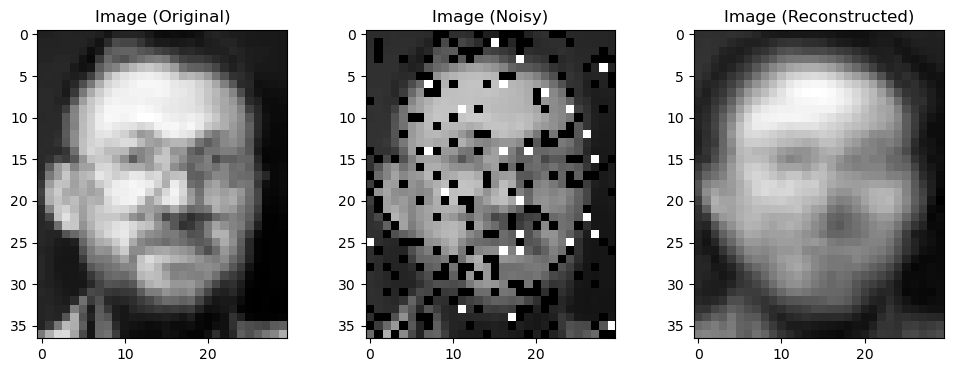

==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 0 time 
Acc(NMI) = 0.7806 (0.8750)
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4211: 1624
==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 1 time 
Acc(NMI) = 0.7417 (0.8607)
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4212: 1590
==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 2 time 
Acc(NMI) = 0.7639 (0.8677)
[Algo=nmf_L21_eps, Noise=(0.2, 0.1), Run=2] RRE=0.1109±0.0000, ACC=0.7620±0.0000, NMI=0.8678±0.0000
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4220: 1820


<Figure size 640x480 with 0 Axes>

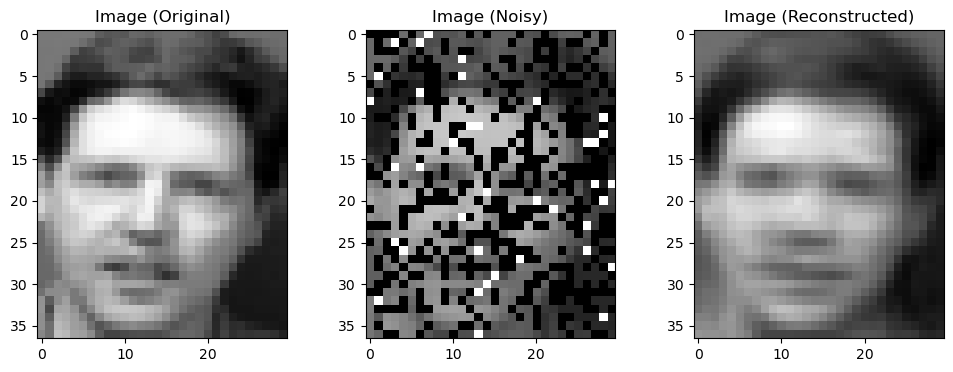

==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 0 time 
Acc(NMI) = 0.7500 (0.8697)
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4221: 1687
==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 1 time 
Acc(NMI) = 0.7583 (0.8690)
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4222: 1629
==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 2 time 
Acc(NMI) = 0.7556 (0.8761)
[Algo=nmf_L21_eps, Noise=(0.4, 0.1), Run=2] RRE=0.1113±0.0000, ACC=0.7546±0.0000, NMI=0.8716±0.0000
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4230: 1754


<Figure size 640x480 with 0 Axes>

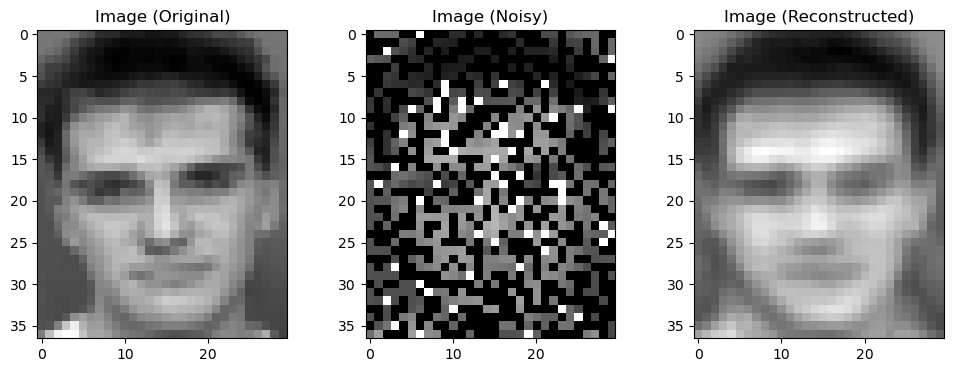

==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 0 time 
Acc(NMI) = 0.7639 (0.8581)
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4231: 1775
==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 1 time 
Acc(NMI) = 0.7417 (0.8644)
algo is <function nmf_L21_eps at 0x12585c5e0>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232
<function nmf_L21_eps at 0x12585c5e0> final run step with local_seed4232: 1944
==> Evaluate Acc and NMI for <function nmf_L21_eps at 0x12585c5e0> for the 2 time 
Acc(NMI) = 0.7500 (0.8701)
[Algo=nmf_L21_eps, Noise=(0.6, 0.1), Run=2] RRE=0.1113±0.0000, ACC=0.7519±0.0000, NMI=0.8642±0.0000
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210
<function nmf_L21_eps_alpha at 0x12585c720> final run step with local_seed4210: 1780


<Figure size 640x480 with 0 Axes>

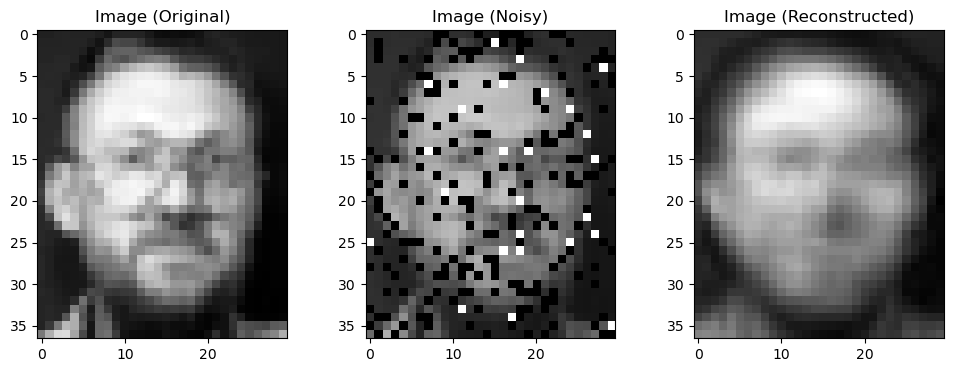

==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 0 time 
Acc(NMI) = 0.7750 (0.8779)
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211
<function nmf_L21_eps_alpha at 0x12585c720> final run step with local_seed4211: 1626
==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 1 time 
Acc(NMI) = 0.7583 (0.8675)
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212
<function nmf_L21_eps_alpha at 0x12585c720> final run step with local_seed4212: 1598
==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 2 time 
Acc(NMI) = 0.7611 (0.8635)
[Algo=nmf_L21_eps_alpha, Noise=(0.2, 0.1), Run=2] RRE=0.1107±0.0000, ACC=0.7648±0.0000, NMI=0.8697±0.0000
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220
<function nmf_L21_eps_alpha at 0x12585c7

<Figure size 640x480 with 0 Axes>

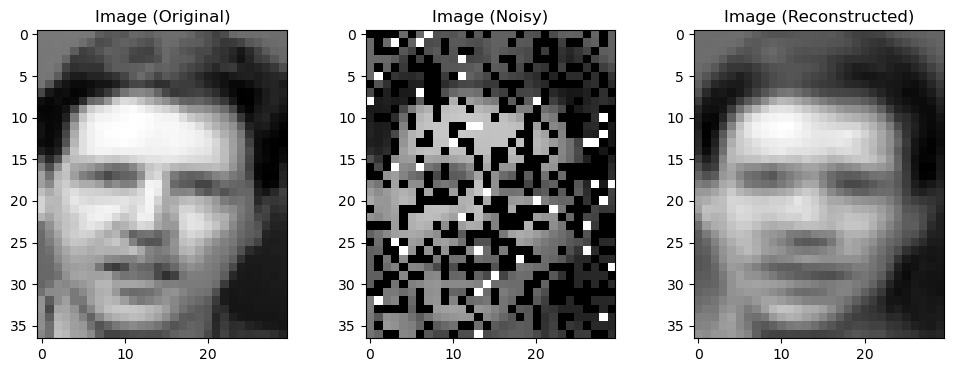

==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 0 time 
Acc(NMI) = 0.7444 (0.8537)
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221
<function nmf_L21_eps_alpha at 0x12585c720> final run step with local_seed4221: 1651
==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 1 time 
Acc(NMI) = 0.7556 (0.8702)
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222
<function nmf_L21_eps_alpha at 0x12585c720> final run step with local_seed4222: 1641
==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 2 time 
Acc(NMI) = 0.7222 (0.8467)
[Algo=nmf_L21_eps_alpha, Noise=(0.4, 0.1), Run=2] RRE=0.1108±0.0000, ACC=0.7407±0.0000, NMI=0.8569±0.0000
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230
<function nmf_L21_eps_alpha at 0x12585c7

<Figure size 640x480 with 0 Axes>

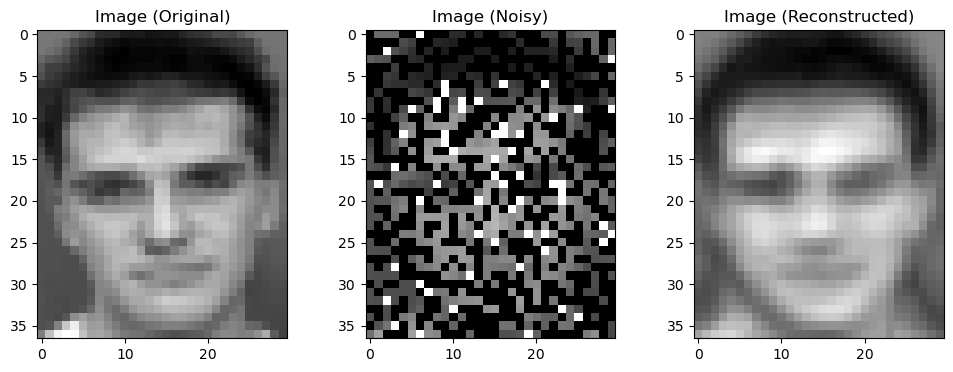

==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 0 time 
Acc(NMI) = 0.7222 (0.8471)
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231
<function nmf_L21_eps_alpha at 0x12585c720> final run step with local_seed4231: 1767
==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 1 time 
Acc(NMI) = 0.7083 (0.8390)
algo is <function nmf_L21_eps_alpha at 0x12585c720>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232
<function nmf_L21_eps_alpha at 0x12585c720> final run step with local_seed4232: 1920
==> Evaluate Acc and NMI for <function nmf_L21_eps_alpha at 0x12585c720> for the 2 time 
Acc(NMI) = 0.7583 (0.8494)
[Algo=nmf_L21_eps_alpha, Noise=(0.6, 0.1), Run=2] RRE=0.1108±0.0000, ACC=0.7296±0.0000, NMI=0.8452±0.0000
algo is <function nmf_CIM at 0x12585c540>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4210: 98


<Figure size 640x480 with 0 Axes>

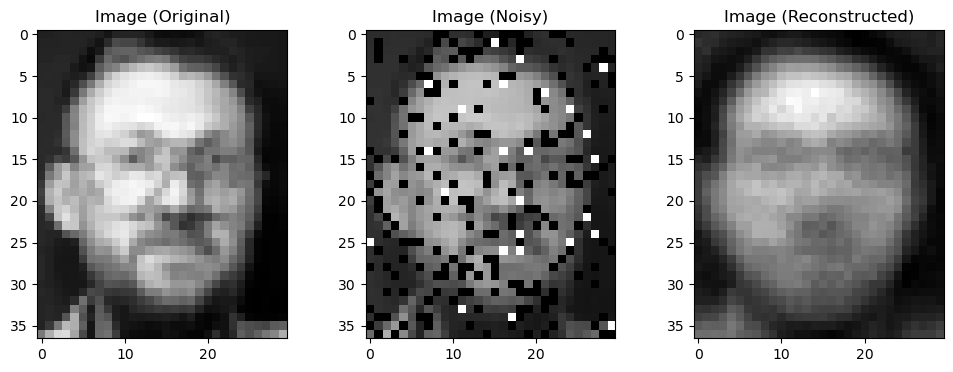

==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 0 time 
Acc(NMI) = 0.6806 (0.8267)
algo is <function nmf_CIM at 0x12585c540>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4211: 102
==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 1 time 
Acc(NMI) = 0.6806 (0.8275)
algo is <function nmf_CIM at 0x12585c540>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4212: 97
==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 2 time 
Acc(NMI) = 0.6861 (0.8305)
[Algo=nmf_CIM, Noise=(0.2, 0.1), Run=2] RRE=0.1475±0.0000, ACC=0.6824±0.0000, NMI=0.8282±0.0000
algo is <function nmf_CIM at 0x12585c540>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4220: 98


<Figure size 640x480 with 0 Axes>

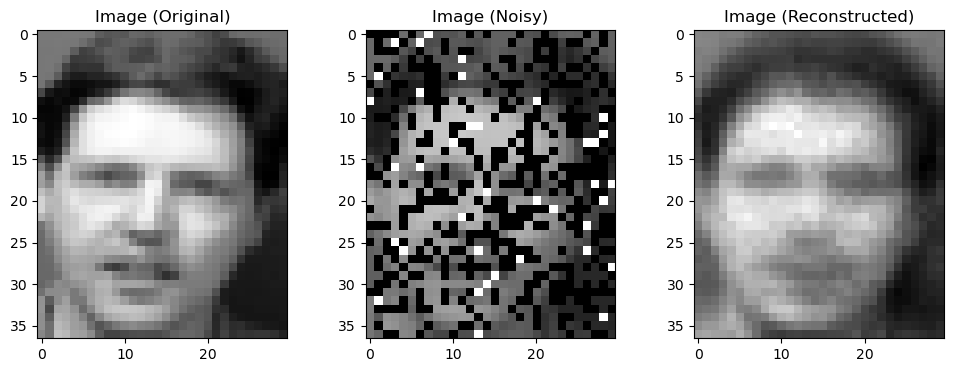

==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 0 time 
Acc(NMI) = 0.6861 (0.8384)
algo is <function nmf_CIM at 0x12585c540>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4221: 102
==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 1 time 
Acc(NMI) = 0.7417 (0.8515)
algo is <function nmf_CIM at 0x12585c540>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4222: 101
==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 2 time 
Acc(NMI) = 0.7167 (0.8654)
[Algo=nmf_CIM, Noise=(0.4, 0.1), Run=2] RRE=0.1475±0.0000, ACC=0.7148±0.0000, NMI=0.8518±0.0000
algo is <function nmf_CIM at 0x12585c540>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4230: 99


<Figure size 640x480 with 0 Axes>

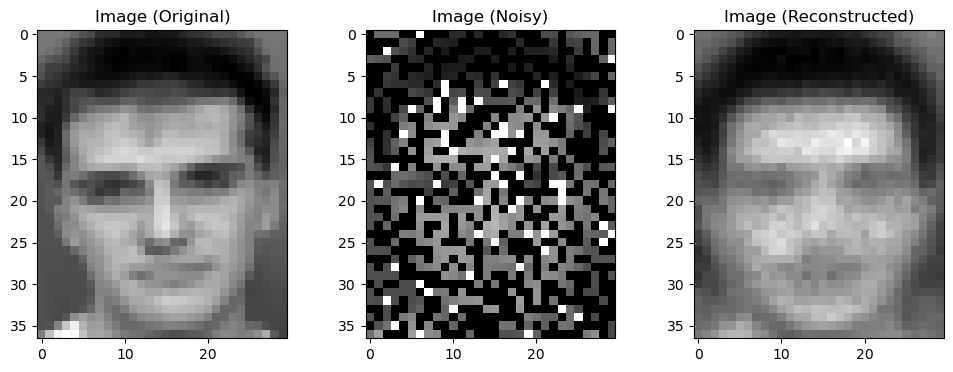

==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 0 time 
Acc(NMI) = 0.6917 (0.8392)
algo is <function nmf_CIM at 0x12585c540>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4231: 101
==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 1 time 
Acc(NMI) = 0.7056 (0.8335)
algo is <function nmf_CIM at 0x12585c540>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM at 0x12585c540> final run step with local_seed4232: 98
==> Evaluate Acc and NMI for <function nmf_CIM at 0x12585c540> for the 2 time 
Acc(NMI) = 0.7167 (0.8553)
[Algo=nmf_CIM, Noise=(0.6, 0.1), Run=2] RRE=0.1481±0.0000, ACC=0.7046±0.0000, NMI=0.8427±0.0000
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4210: 484


<Figure size 640x480 with 0 Axes>

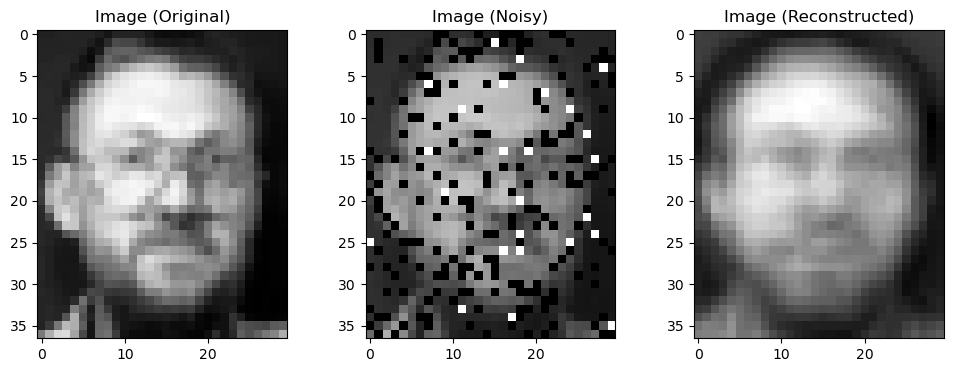

==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 0 time 
Acc(NMI) = 0.6278 (0.7932)
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4211: 460
==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 1 time 
Acc(NMI) = 0.6806 (0.8249)
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4212: 431
==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 2 time 
Acc(NMI) = 0.7306 (0.8545)
[Algo=nmf_CIM_delta, Noise=(0.2, 0.1), Run=2] RRE=0.1198±0.0000, ACC=0.6796±0.0000, NMI=0.8242±0.0000
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220
<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4220: 3


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<Figure size 640x480 with 0 Axes>

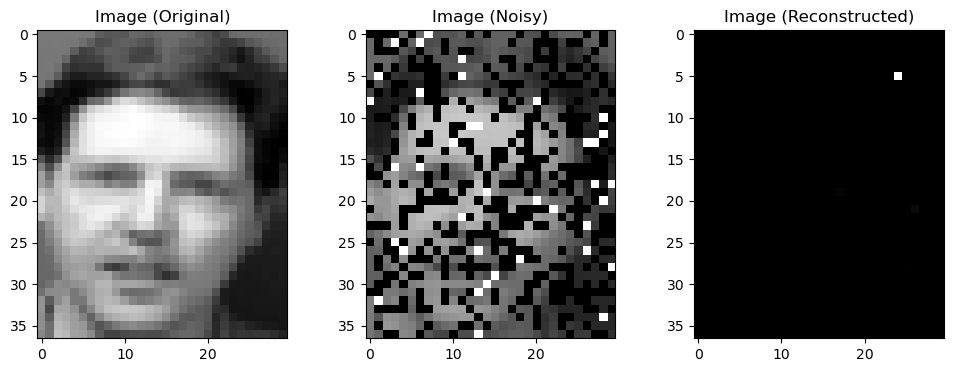

==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 0 time 
Acc(NMI) = 0.1361 (0.1911)
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221
<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4221: 3
==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 1 time 


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


Acc(NMI) = 0.1389 (0.1992)
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4222: 423
==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 2 time 
Acc(NMI) = 0.6861 (0.8322)
[Algo=nmf_CIM_delta, Noise=(0.4, 0.1), Run=2] RRE=0.7063±0.0000, ACC=0.3204±0.0000, NMI=0.4075±0.0000
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230
<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4230: 3


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<Figure size 640x480 with 0 Axes>

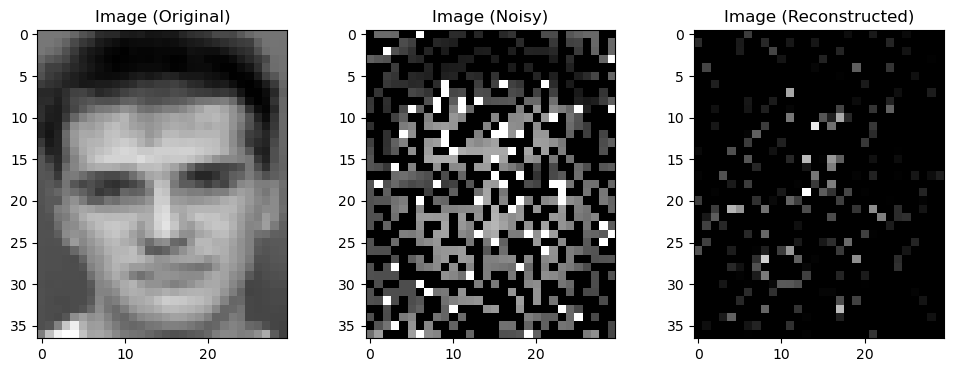

==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 0 time 
Acc(NMI) = 0.1389 (0.1987)
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4231: 448
==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 1 time 
Acc(NMI) = 0.7056 (0.8421)
algo is <function nmf_CIM_delta at 0x12585c860>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_delta at 0x12585c860> final run step with local_seed4232: 568
==> Evaluate Acc and NMI for <function nmf_CIM_delta at 0x12585c860> for the 2 time 
Acc(NMI) = 0.7278 (0.8296)
[Algo=nmf_CIM_delta, Noise=(0.6, 0.1), Run=2] RRE=0.4139±0.0000, ACC=0.5241±0.0000, NMI=0.6234±0.0000
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4210: 98


<Figure size 640x480 with 0 Axes>

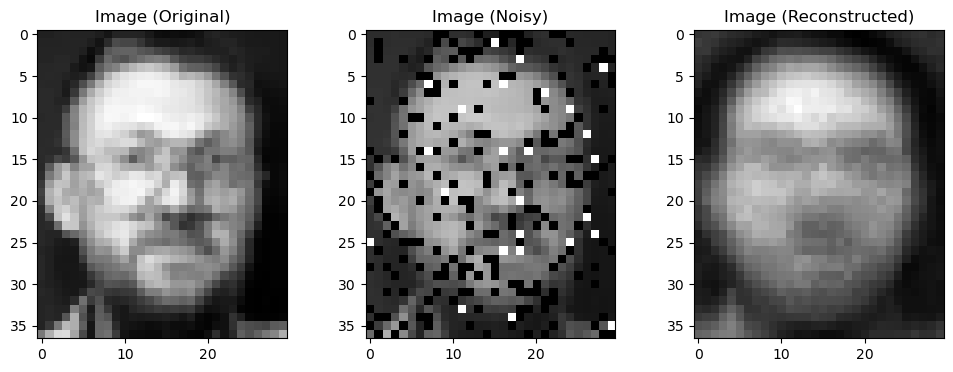

==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 0 time 
Acc(NMI) = 0.6556 (0.8075)
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.2, 0.1), iter_time is 1, the local_seed is 4211


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4211: 99
==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 1 time 
Acc(NMI) = 0.6639 (0.8051)
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.2, 0.1), iter_time is 2, the local_seed is 4212


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4212: 95
==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 2 time 
Acc(NMI) = 0.6972 (0.8358)
[Algo=nmf_CIM_eps, Noise=(0.2, 0.1), Run=2] RRE=0.1485±0.0000, ACC=0.6722±0.0000, NMI=0.8162±0.0000
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.4, 0.1), iter_time is 0, the local_seed is 4220


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4220: 96


<Figure size 640x480 with 0 Axes>

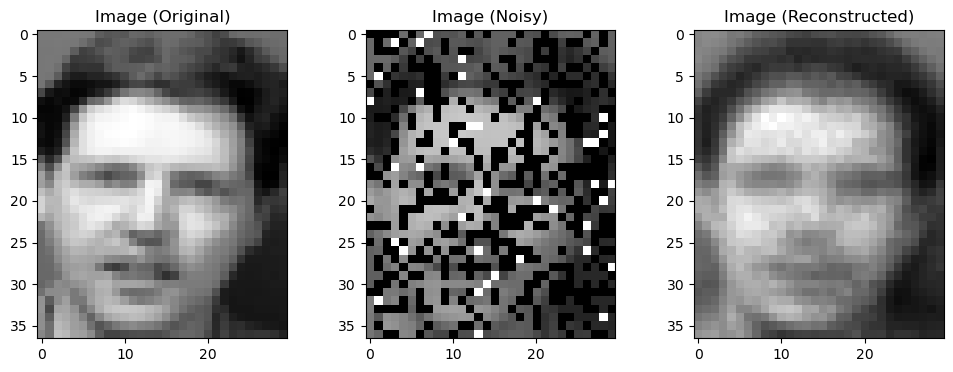

==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 0 time 
Acc(NMI) = 0.7250 (0.8405)
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.4, 0.1), iter_time is 1, the local_seed is 4221


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4221: 99
==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 1 time 
Acc(NMI) = 0.7139 (0.8388)
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.4, 0.1), iter_time is 2, the local_seed is 4222


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4222: 102
==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 2 time 
Acc(NMI) = 0.7056 (0.8407)
[Algo=nmf_CIM_eps, Noise=(0.4, 0.1), Run=2] RRE=0.1471±0.0000, ACC=0.7148±0.0000, NMI=0.8400±0.0000
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.6, 0.1), iter_time is 0, the local_seed is 4230


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4230: 97


<Figure size 640x480 with 0 Axes>

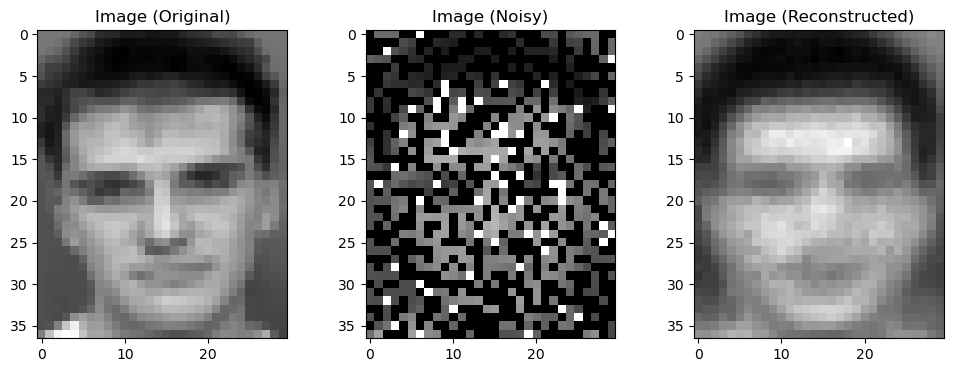

==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 0 time 
Acc(NMI) = 0.7278 (0.8485)
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.6, 0.1), iter_time is 1, the local_seed is 4231


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4231: 100
==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 1 time 
Acc(NMI) = 0.6778 (0.8204)
algo is <function nmf_CIM_eps at 0x12585c9a0>,noise is (0.6, 0.1), iter_time is 2, the local_seed is 4232


/var/folders/m3/fcr16lh54y30bntgwn34tg7w0000gn/T/ipykernel_24375/1556366779.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


<function nmf_CIM_eps at 0x12585c9a0> final run step with local_seed4232: 96
==> Evaluate Acc and NMI for <function nmf_CIM_eps at 0x12585c9a0> for the 2 time 
Acc(NMI) = 0.6833 (0.8312)
[Algo=nmf_CIM_eps, Noise=(0.6, 0.1), Run=2] RRE=0.1480±0.0000, ACC=0.6963±0.0000, NMI=0.8334±0.0000
algo is <function nmf_CIM_default at 0x12585c900>,noise is (0.2, 0.1), iter_time is 0, the local_seed is 4210


NameError: name 'cim_objective' is not defined

In [14]:
dataset_orl = 'ORL'
# algos = [nmf_L1,nmf_L2,nmf_L21]
# algos = [nmf_L2]
algos = [nmf_L1,nmf_L21_alpha,nmf_L21_eps,nmf_L21_eps_alpha,nmf_CIM,nmf_CIM_delta,nmf_CIM_eps]
noise_list = [(0.2,0.1),(0.4,0.1),(0.6,0.1)]
r = 3

df_result = robost_pipeline(dataset = dataset_orl, algos=algos, noise_list=noise_list,n_runs = r,global_seed = 42)
# dataset_yale = 'CroppedYaleB'
# df_result_yale = robost_pipeline(dataset_yale, algos, noise_list,n_runs = r,global_seed = 42)

## 7. Visualization